In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,49493,None,None,85796.396283
2020-06-13,49494,None,None,79686.127905
2020-06-14,49495,None,None,74019.434607
2020-06-15,49496,None,None,68680.588255
2020-06-16,49497,None,None,63922.819599
...,...,...,...,...
2021-04-17,49802,None,None,28273.854419
2021-04-18,49803,None,None,26988.385111
2021-04-19,49804,None,None,25846.461415


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-21_2021-04-21-18-16.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-20_2021-04-20-22-12.pickle


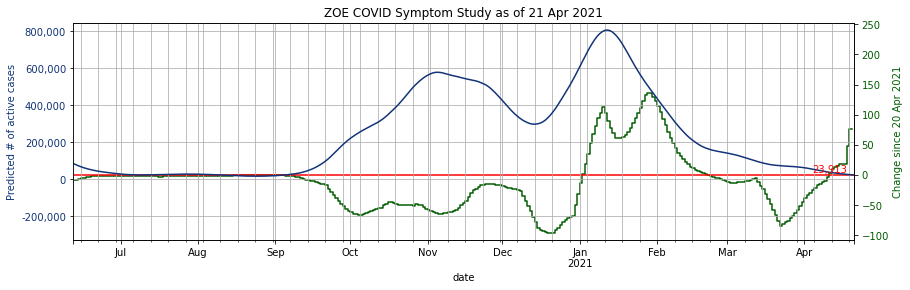

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

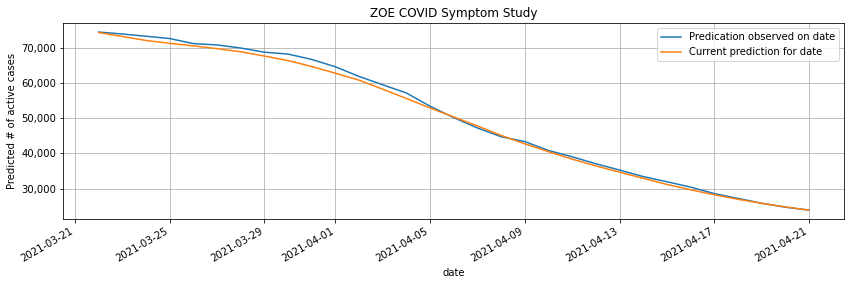

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-04-21_2021-04-21-18-16.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
15,"Kingston upon Hull, City of",E06000010,0.650244
247,Nuneaton and Bedworth,E07000219,0.460485
281,Newcastle upon Tyne,E08000021,0.441575
267,Bury,E08000002,0.319971
143,Blaby,E07000129,0.269132
150,Watford,E07000103,0.237484
210,Broxtowe,E07000172,0.212898
218,South Staffordshire,E07000196,0.159830
274,Wigan,E08000010,0.154365
297,Falkirk,S12000014,0.151691
